<a href="https://colab.research.google.com/github/Kuyas/TimeSeriesEntropy/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!ls

drive  sample_data


In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import time as time
import seaborn as sns
import pickle
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [0]:
def save_obj(obj, name ):
    with open('/content/drive/My Drive/TimeSeries/save/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/content/drive/My Drive/TimeSeries/save/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Import Data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
DateTime,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,0.001117,0.002037,0.010902,0.017361,0.020202,0.181619,0.280977,0.661319,0.258621,0.0,NNW,0.392857,Aotizhongxin
2013-03-01 01:00:00,2,2013,3,1,1,0.005587,0.006110,0.010902,0.017361,0.020202,0.181619,0.273997,0.664884,0.268025,0.0,N,0.419643,Aotizhongxin
2013-03-01 02:00:00,3,2013,3,1,2,0.004469,0.005092,0.013837,0.027778,0.020202,0.172158,0.273997,0.670232,0.268025,0.0,NNW,0.500000,Aotizhongxin
2013-03-01 03:00:00,4,2013,3,1,3,0.003352,0.004073,0.031447,0.031250,0.020202,0.169792,0.268761,0.688057,0.249216,0.0,NW,0.276786,Aotizhongxin
2013-03-01 04:00:00,5,2013,3,1,4,0.000000,0.001018,0.034382,0.034722,0.020202,0.169792,0.258290,0.700535,0.247649,0.0,N,0.178571,Aotizhongxin


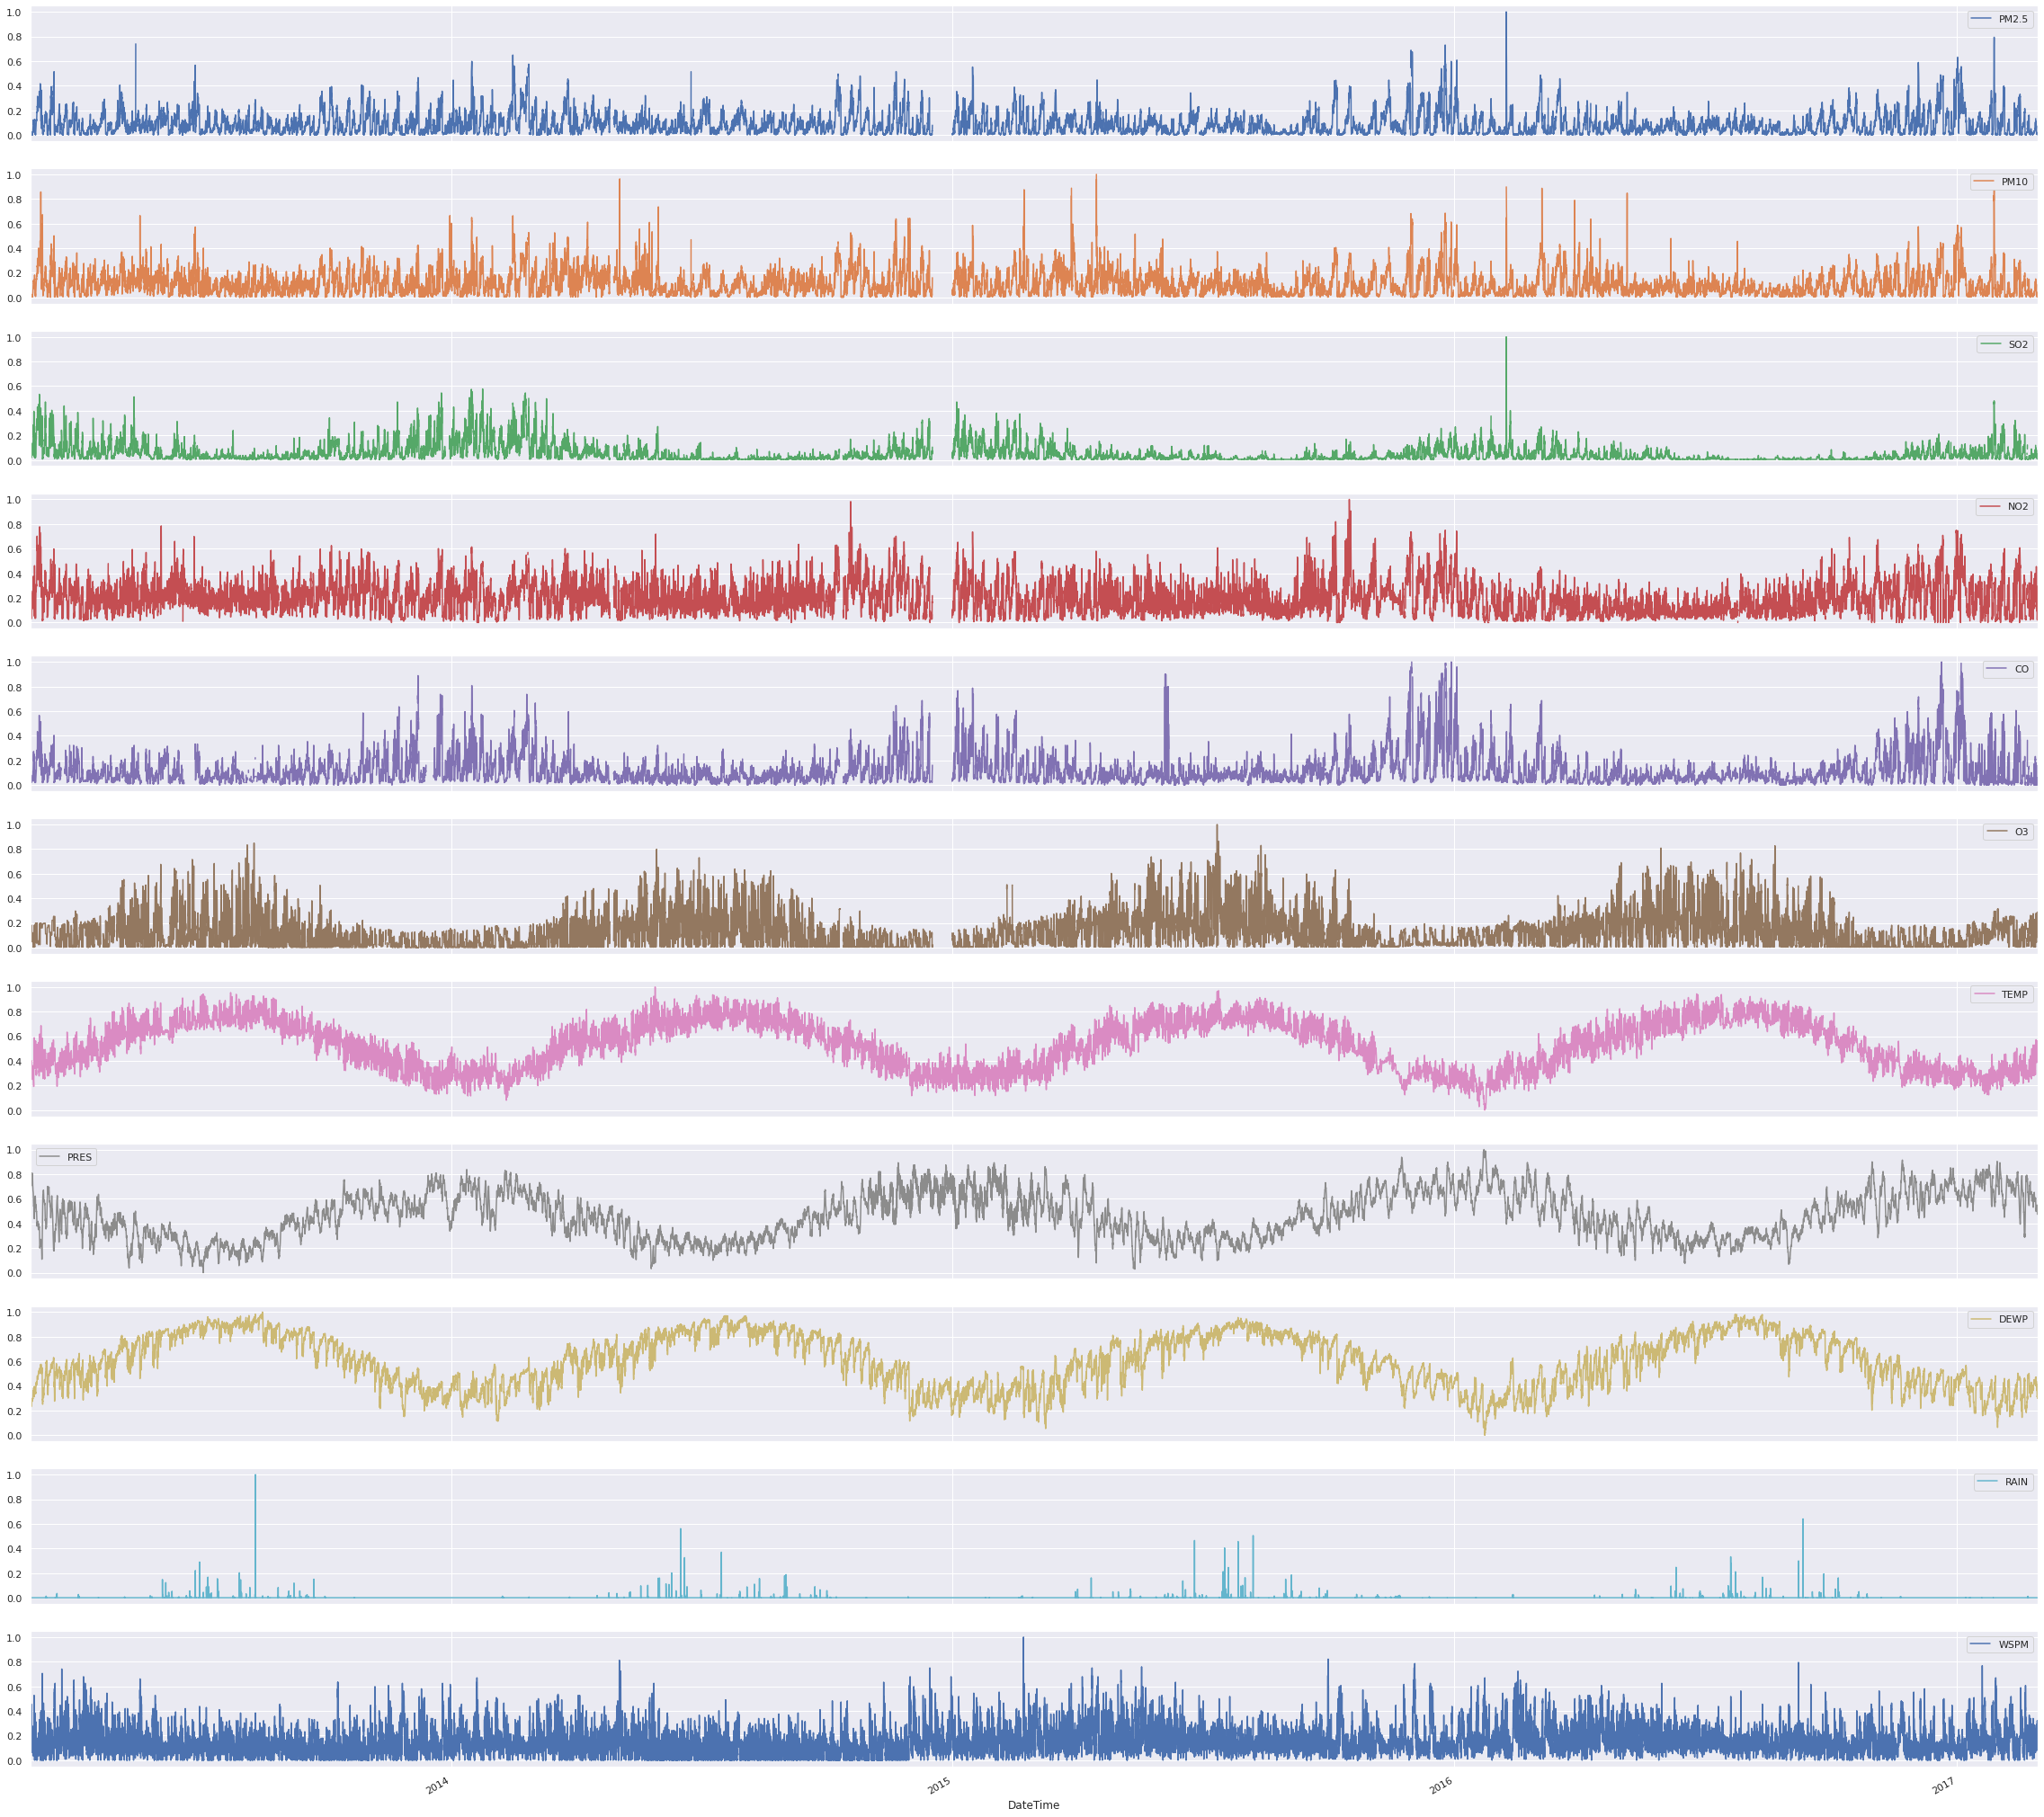

In [0]:
df = pd.read_csv("/content/drive/My Drive/TimeSeries/PRSA_Data_Aotizhongxin_20130301-20170228.csv") #read csv
df1 = pd.to_datetime(df.iloc[:,1:5]) # convert the year-month-day-hour column to datetime format for time series
Aotizhongxin = pd.concat([df, df1], axis=1, sort=False) # concat the datetime to original csv
Aotizhongxin = Aotizhongxin.rename(columns = {0:"DateTime"}) # rename the concat'd column
Aotizhongxin = Aotizhongxin.set_index('DateTime') # make the concat'd column as the index/serial
cols_to_norm = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
Aotizhongxin[cols_to_norm] = Aotizhongxin[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # Normalize the columns
display(Aotizhongxin.head())

cols = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','wd','WSPM']
col = ['PM2.5']
Aotizhongxin[cols].plot(subplots=True, linestyle='-', figsize=(40, 40))
plt.show()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
DateTime,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,0.001136,0.004012,0.041052,0.022986,0.020202,0.197735,0.246552,0.709797,0.247191,0.0,E,0.05,Changping
2013-03-01 01:00:00,2,2013,3,1,1,0.001136,0.001003,0.018451,0.018524,0.020202,0.197735,0.243103,0.719039,0.258427,0.0,ENE,0.07,Changping
2013-03-01 02:00:00,3,2013,3,1,2,0.001136,0.001003,0.070111,0.049753,0.030303,0.172081,0.234483,0.719039,0.243981,0.0,ENE,0.02,Changping
2013-03-01 03:00:00,4,2013,3,1,3,0.001136,0.004012,0.037823,0.027447,0.020202,0.188406,0.224138,0.728281,0.256822,0.0,NNE,0.10,Changping
2013-03-01 04:00:00,5,2013,3,1,4,0.001136,0.001003,0.044281,0.027447,0.020202,0.188406,0.225862,0.737523,0.252006,0.0,N,0.21,Changping


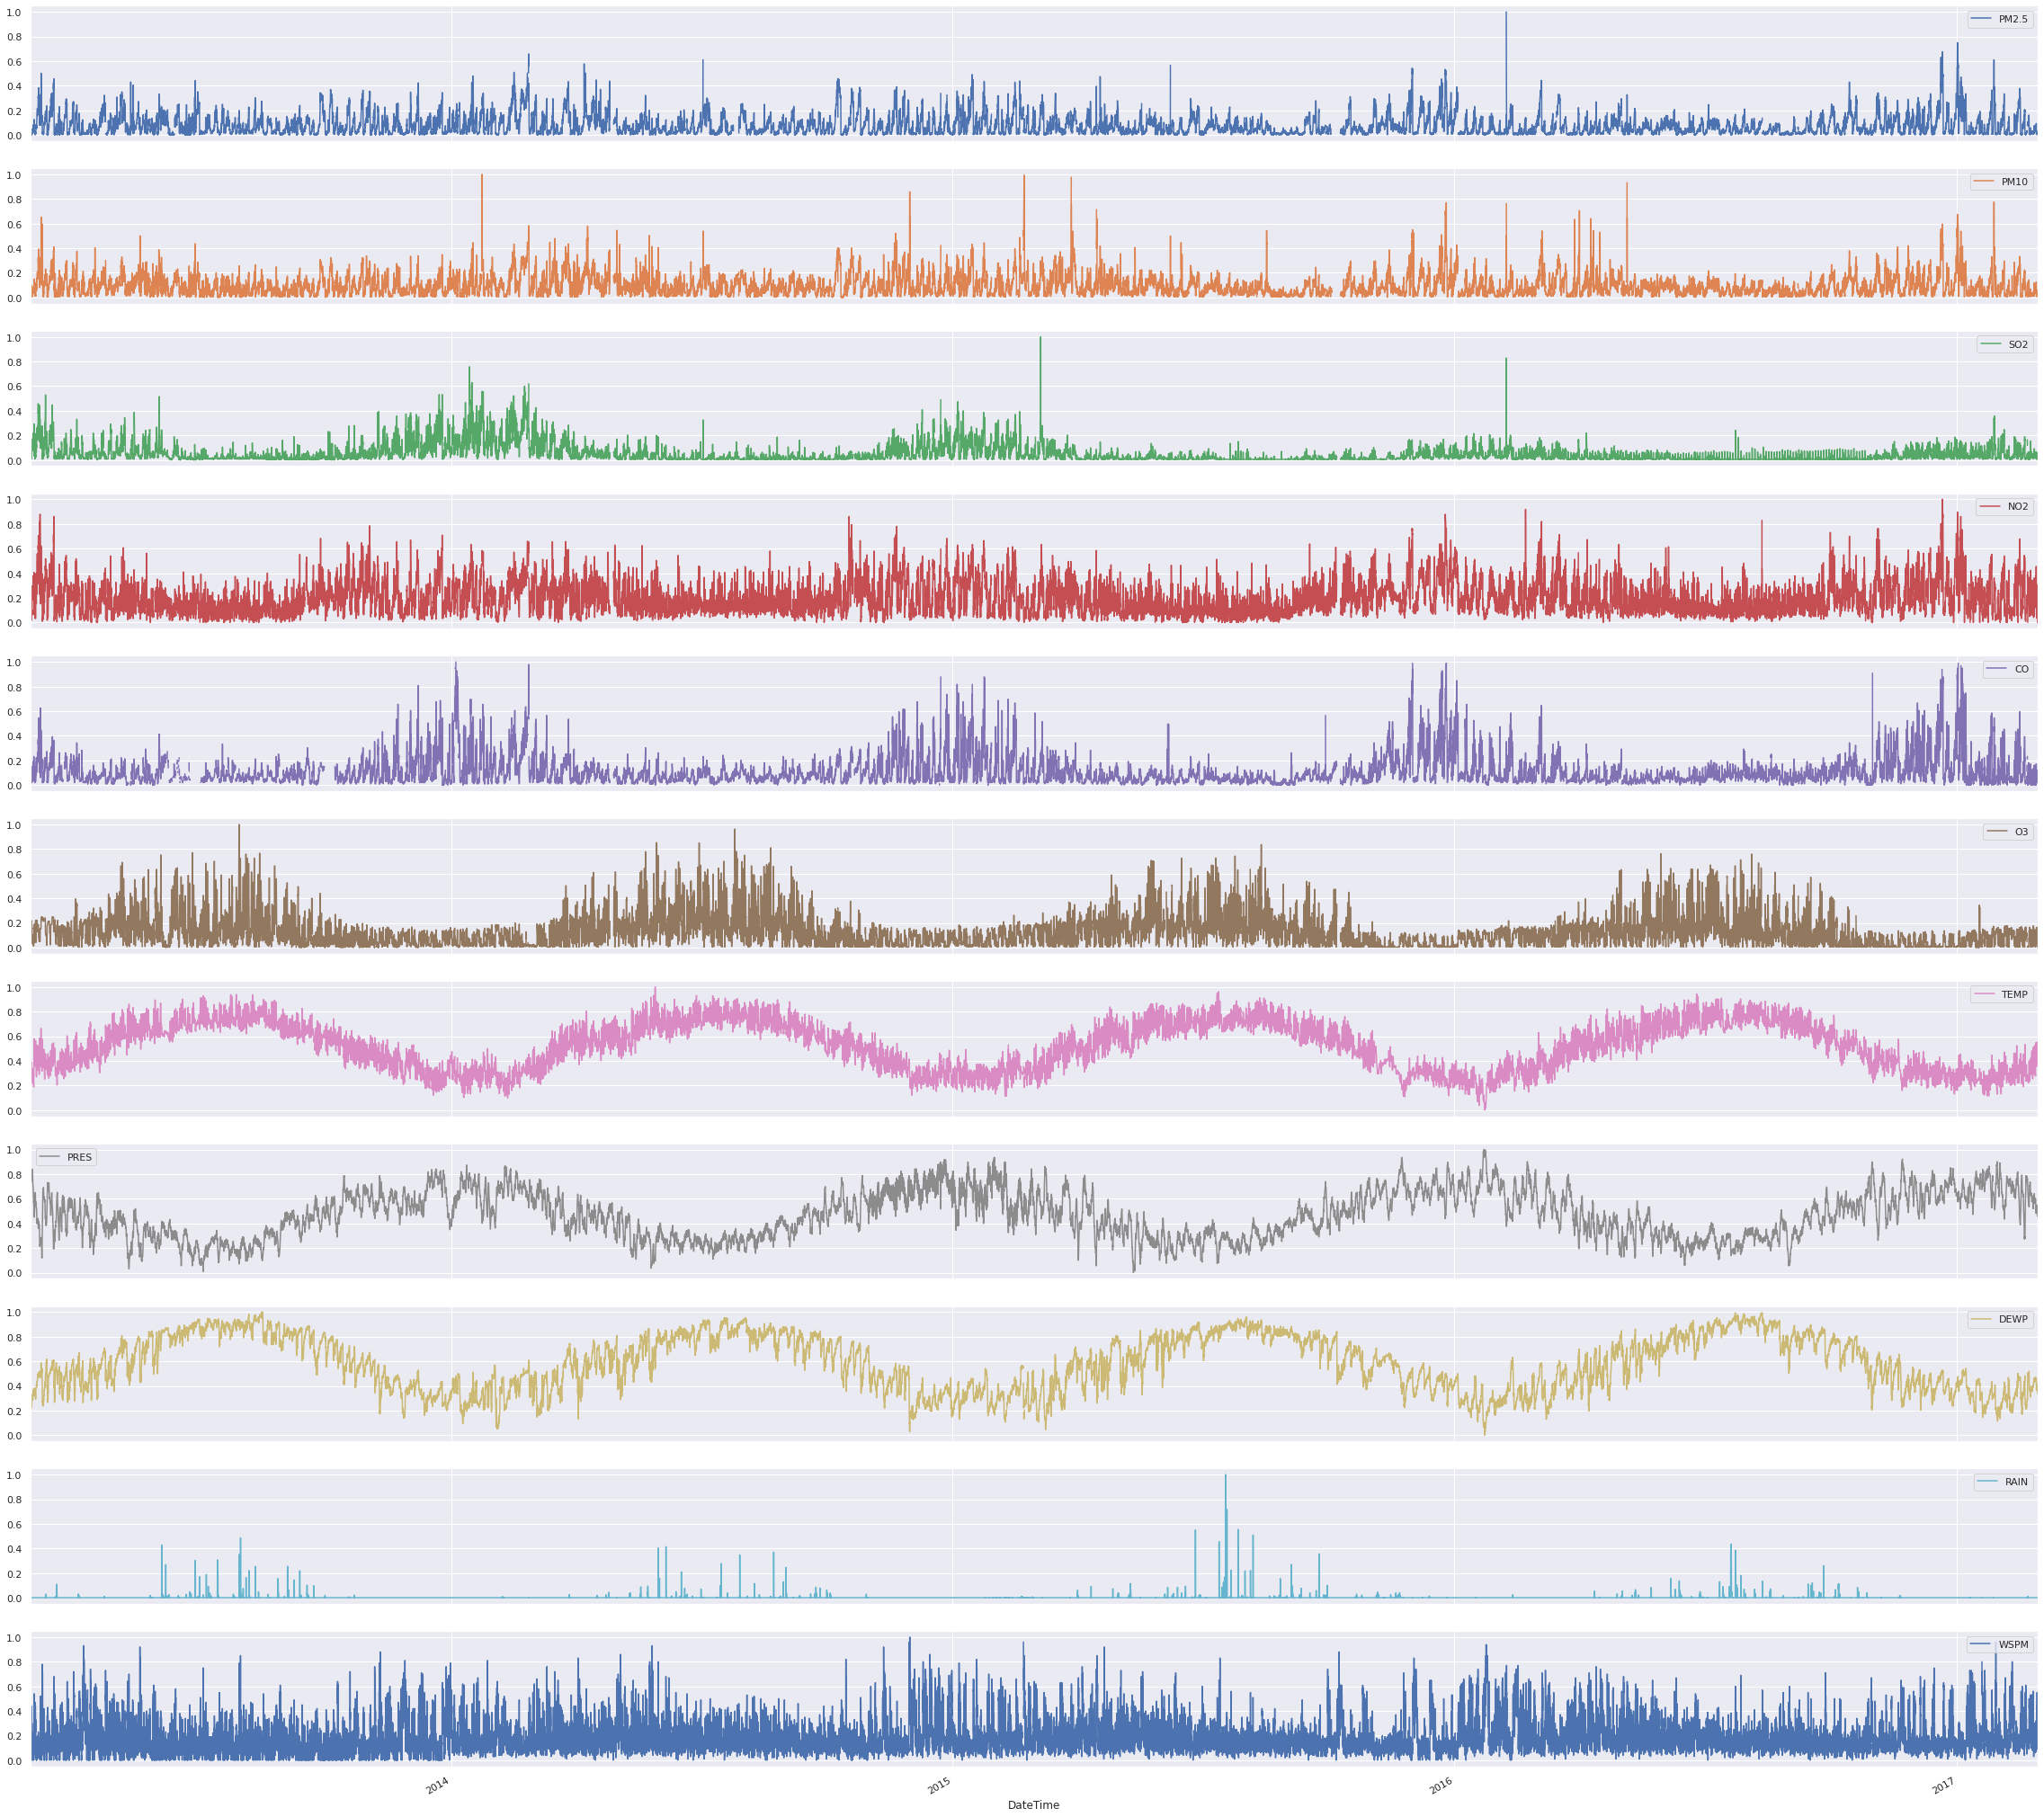

In [0]:
df = pd.read_csv("/content/drive/My Drive/TimeSeries/PRSA_Data_Changping_20130301-20170228.csv") #read csv
df1 = pd.to_datetime(df.iloc[:,1:5]) # convert the year-month-day-hour column to datetime format for time series
Changping = pd.concat([df, df1], axis=1, sort=False) # concat the datetime to original csv
Changping = Changping.rename(columns = {0:"DateTime"}) # rename the concat'd column
Changping = Changping.set_index('DateTime') # make the concat'd column as the index/serial
cols_to_norm = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
Changping[cols_to_norm] = Changping[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # Normalize the columns
display(Changping.head())

cols = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','wd','WSPM']
col = ['PM2.5']
Changping[cols].plot(subplots=True, linestyle='-', figsize=(40, 40))
plt.show()

## Entropy Measures

In [0]:
def ApproxEntropy(U, m, r) -> float:
    """Approximate_entropy."""

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [0]:
def sampleEntropy(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0

    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])
    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similarly for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return sampleEntropy
    return -np.log(A / B)

In [0]:
def coarse_graining(tau, signal):
    # signal length
    N = len(signal)
    # Coarse_graining signal initialisation
    y = np.zeros(int(len(signal) / tau))
    for j in range(0, int(N / tau)):
        y[j] = sum(signal[i] / tau for i in range(int((j - 1) * tau), int(j * tau)))
    return y


def mse(m, r, signal, y_axis_scale=None):
    # Output initialisation
    if y_axis_scale == None:
        y_axis_scale = int((len(signal) * 40) / len(signal))
    y = np.zeros(y_axis_scale + 1)
    y[0] = float('nan')
    for i in range(1, y_axis_scale + 1):
        coarse_y = coarse_graining(i, signal)
        y[i] = sampleEntropy(coarse_y, m, r)
    return y

In [0]:
def embed_seq(X, Tau, D):
    shape = (X.size - Tau * (D - 1), D)
    strides = (X.itemsize, Tau * X.itemsize)
    return np.lib.stride_tricks.as_strided(X, shape=shape, strides=strides)
    
def match(signal, m, r):
    N = len(signal)

    Em = embed_seq(signal, 1, m)
    Emp = embed_seq(signal, 1, m + 1)

    Cm, Cmp = np.zeros(N - m - 1) + 1e-100, np.zeros(N - m - 1) + 1e-100
    # in case there is 0 after counting. Log(0) is undefined.

    for i in range(0, N - m):
        for j in range(i + 1, N - m):  # no self-match
            # if max(abs(Em[i]-Em[j])) <= R:  # v 0.01_b_r1
            if in_range(Em[i], Em[j], r):
                Cm[i] += 1
                # if max(abs(Emp[i] - Emp[j])) <= R: # v 0.01_b_r1
                if abs(Emp[i][-1] - Emp[j][-1]) <= r:  # check last one
                    Cmp[i] += 1


    return sum(Cm), sum(Cmp)

def in_range(Template, Scroll, Distance):
  for i in range(0,  len(Template)):
        if abs(Template[i] - Scroll[i]) > Distance:
            return False
  return True

def cmse(signal, m, r, y_axis_scale):
    Nm = 0
    Nmp = 0
    y = np.zeros(y_axis_scale + 1)
    y[0] = float('nan')
    for i in range(1, y_axis_scale + 1):
        for j in range(0, i):
            coarse_y = coarse_graining(i, signal[i:])
            (Cm, Cmp) = match(coarse_y, m, r)
            Nm += Cm
            Nmp += Cmp
        y[i] = -np.log(Nmp / Nm)
    return y

In [0]:
def embed_seq(X, Tau, D):
    shape = (X.size - Tau * (D - 1), D)
    strides = (X.itemsize, Tau * X.itemsize)
    return np.lib.stride_tricks.as_strided(X, shape=shape, strides=strides)
    
def match_fmse(signal, m, r,f):
    N = len(signal)

    Em = embed_seq(signal, 1, m)
    # print(signal.shape, Em.shape)
    Emp = embed_seq(signal, 1, m + 1)
    # simc = np.abs(Em-Emp).max(axis=1)

    Cm, Cmp = np.zeros(N - m - 1) + 1e-100, np.zeros(N - m - 1) + 1e-100
    # in case there is 0 after counting. Log(0) is undefined.

    for i in range(0, N - m):
        for j in range(i + 1, N - m):  # no self-match
            # if max(abs(Em[i]-Em[j])) <= f:  # v 0.01_b_r1
            if in_range(Em[i], Em[j], f):
                Cm[i] += (1 - max(np.abs(Em[i]-Em[j]))/f)
                # if max(abs(Emp[i] - Emp[j])) <= R: # v 0.01_b_r1
                if abs(Emp[i][-1] - Emp[j][-1]) <= r:  # check last one
                    Cmp[i] += max(np.abs(Emp[i]-Emp[j]))   

    return sum(Cm), sum(Cmp)

def in_range(Template, Scroll, Distance):
  for i in range(0,  len(Template)):
        if abs(Template[i] - Scroll[i]) > Distance:
            return False
  return True


def fmse_new(signal,f, m, r, y_axis_scale):
  Nm = 0
  Nmp = 0
  y = np.zeros(y_axis_scale + 1)
  y[0] = float('nan')
  for i in range(1, y_axis_scale + 1):
      for j in range(0, i):
          coarse_y = coarse_graining(i, signal[i:])
          (Cm, Cmp) = match_fmse(coarse_y, m, r,f)
          Nm += Cm
          Nmp += Cmp
      y[i] = -np.log(Nmp / Nm)
  return y


## FMSE
1. Coarse graining
2. `B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])`
3. f = 0.2, similarity function =>
4. Fsampen = -log(C/B)

In [0]:
def similarity(A,B,f):
  simc = np.abs(A-B).max(axis=1)
  sim = np.abs(A-B).max(axis=1)<f
  # print(sim)
  similar = np.zeros(len(sim))+ 1e-100
  for i in range(len(sim)):
    if i == True:
      similar[i] = 1 - simc[i]/f
    else:
      continue
  return (np.sum(similar))

# def fmse(signal,f=0.2,m=2,r=3,y_axis_scale):
#   pass

def fmse(signal,f=0.2,m=2,r=3,y_axis_scale=40):
  B = 0.0
  y_f = np.zeros(y_axis_scale + 1)
  C = 0.0
  F = 0.0
  y_f[0] = float('nan')
  for j in range(1, y_axis_scale + 1):
    B = 0.0
    y = []
    C = 0.0
    # F = 0.0/
    y = coarse_graining(j, signal)
    N = len(y)
    xmi = np.array([y[i : i + m] for i in range(N - m)])
    xmj = np.array([y[i : i + m] for i in range(N - m + 1)])
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) < r) - 1 for xmii in xmi])
    m += 1
    xm = np.array([y[i : i + m] for i in range(N - m + 1)])
    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) < f) - 1 for xmi in xm])
    C = np.sum([(similarity(xmi,xm,f)) for xmi in xm])
    # print(C,B)
    # if np.isfinite(np.log(C/B)):
    y_f[j] = -np.log(A/B) 
  # print(F)
  # print(F/j)
  # print(np.abs(F/(j-1)))
  return y_f

  

# series = np.abs(np.random.randn(2000))
# # print("series",series)
# series = Aotizhongxin['PM2.5']
# fmse(series,0.2*np.std(series),2,0.15*np.std(series))

## Running the code With White Noise

In [0]:
# Variable definition
nb_signal = 100 # [10,100]
N = 2000 #[1000,2000,10000]
y_axis_scale = 40
m = 2
np.random.seed(0)
filename = "white_noise_"+str(nb_signal)+"_"+str(N)
# nb_signal white noise of N samples generation
white_noise = []
for i in range(0, nb_signal):
    white_noise.append(np.abs(np.random.normal(0,1,N)))

In [68]:
# MSE calculation for each white noise signal
MSE = np.zeros(y_axis_scale + 1)
CV_MSE_mat = np.zeros((nb_signal,y_axis_scale+1))
for j in range(0, nb_signal):
    signal = white_noise[j]
    MSE_temp = mse(m, 0.15 * np.std(signal), signal)
    for k in range(0, len(MSE_temp)):
        MSE[k] += MSE_temp[k]
        CV_MSE_mat[j][k] = MSE_temp[k]
MSE /= nb_signal
CV_MSE_MEAN = np.nanmean(CV_MSE_mat,axis=0)
CV_MSE_STD = np.nanstd(CV_MSE_mat,axis=0)
CV_MSE = CV_MSE_STD/CV_MSE_MEAN

save_obj(MSE,filename+"_MSE")
save_obj(CV_MSE,filename+"_CV_MSE")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [69]:
CMSE = np.zeros(y_axis_scale + 1)
CV_CMSE_mat = np.zeros((nb_signal,y_axis_scale+1))
for j in range(0, nb_signal):
    print(j)
    signal = white_noise[j]
    CMSE_temp = cmse(signal, m, 0.15 * np.std(signal), y_axis_scale)
    for k in range(0, len(CMSE_temp)):
        CMSE[k] += CMSE_temp[k]
        CV_CMSE_mat[j][k] = CMSE_temp[k]

# mean of the nb_signal CMSE
CMSE /= nb_signal
CV_CMSE_MEAN = np.nanmean(CV_CMSE_mat,axis=0)
CV_CMSE_STD = np.nanstd(CV_CMSE_mat,axis=0)
CV_CMSE = CV_CMSE_STD/CV_CMSE_MEAN
filename_save = filename + "CMSE"
save_obj(CMSE,filename+"_CMSE")
save_obj(CV_CMSE,filename+"_CV_CMSE")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [70]:
# y_axis_scale = y_axis_scale+5
FMSE = np.zeros(y_axis_scale+1)
CV_FMSE_mat = np.zeros((nb_signal,y_axis_scale+1))
for j in range(0,nb_signal):
  print(j)
  signal = white_noise[j]
  FMSE_temp = fmse_new(signal,0.2*np.std(signal),m,0.15*np.std(signal),y_axis_scale)
  for k in range(0,len(FMSE_temp)):
    FMSE[k] += FMSE_temp[k]
    CV_FMSE_mat[j][k] = FMSE_temp[k]
FMSE /= nb_signal
# y_axis_scale = y_axis_scale-5
# FMSE = interpolate_gaps(FMSE)
CV_FMSE_MEAN = np.nanmean(CV_FMSE_mat,axis=0)
CV_FMSE_STD = np.nanstd(CV_FMSE_mat,axis=0)
CV_FMSE = CV_FMSE_STD/CV_FMSE_MEAN
filename_save = filename + "FMSE"


save_obj(FMSE,filename+"_FMSE")
save_obj(CV_FMSE,filename+"_CV_FMSE")

from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [0]:
def complexity_index(sig, low, upp):
    ci = np.nansum(sig[low:upp])
    return ci

## Running Code with Pollution Data

In [0]:
# Variable definition
pollution_series = [Aotizhongxin['PM2.5'],Changping['PM2.5']] 
nb_signal = 1
N = len(pollution_series)
y_axis_scale = 40
m = 2

# nb_signal white noise of N samples generation
white_noise = []
for i in range(0, nb_signal):
    white_noise.append(pollution_series[i])

In [0]:
# MSE calculation for each white noise signal
MSE = np.zeros(y_axis_scale + 1)
for j in range(0, nb_signal):
    signal = white_noise[j]
    MSE_temp = mse(m, 0.15 * np.std(signal), signal)
    for k in range(0, len(MSE_temp)):
        MSE[k] += MSE_temp[k]
MSE /= nb_signal

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


In [0]:
CMSE = np.zeros(y_axis_scale + 1)
for j in range(0, nb_signal):
    signal = white_noise[j]
    CMSE_temp = cmse(signal, m, 0.15 * np.std(signal), y_axis_scale)
    for k in range(0, len(CMSE_temp)):
        CMSE[k] += CMSE_temp[k]

# mean of the nb_signal CMSE
CMSE /= nb_signal

In [0]:
y_axis_scale = y_axis_scale+5
FMSE = np.zeros(y_axis_scale+1)
for j in range(0,nb_signal):
  signal = white_noise[j]
  FMSE_temp = fmse(signal,0.2*np.std(signal),m,0.15*np.std(signal),y_axis_scale)
  for k in range(0,len(FMSE_temp)):
    FMSE[k] += FMSE_temp[k]
FMSE /= nb_signal
y_axis_scale = y_axis_scale-5
# FMSE = interpolate_gaps(FMSE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


## Plots

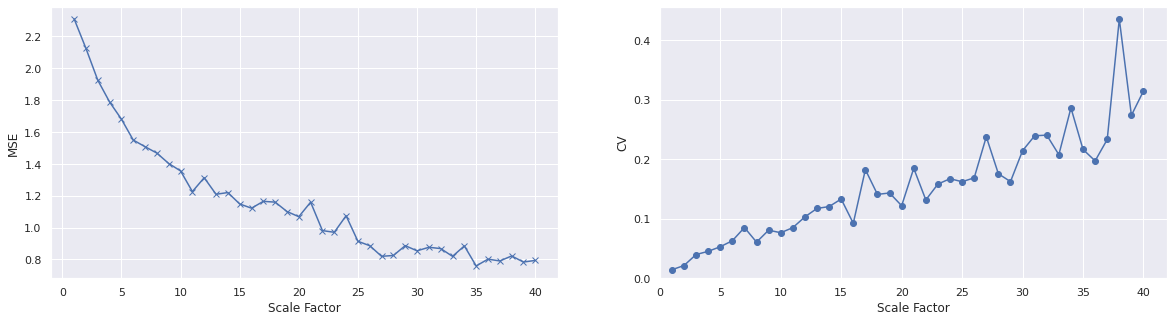

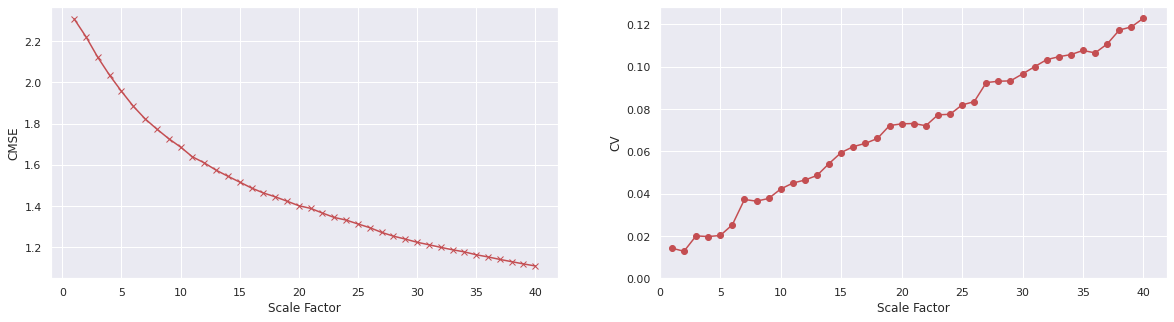

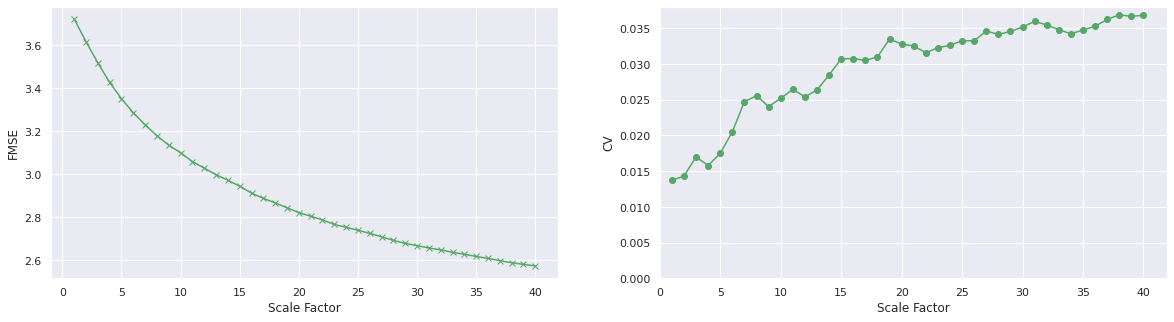

Complexity index of MSE = 45.62971821643413
Complexity index of CMSE = 58.14554455185842
Complexity index of FMSE = 113.81044831627086


In [0]:
# fig = plt.figure(figsize=(20,5))
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
axes[0].plot((testA), "b-x")
axes[1].plot((testB), "b-o")
axes[0].set_xlabel("Scale Factor")
axes[0].set_ylabel("MSE")
axes[1].set_xlabel("Scale Factor")
axes[1].set_ylabel("CV")
plt.xlim(0)
plt.ylim(0)
plt.show()

fig1, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
axes[0].plot((CMSE), "r-x")
axes[1].plot((CV_CMSE), "r-o")
axes[0].set_xlabel("Scale Factor")
axes[0].set_ylabel("CMSE")
axes[1].set_xlabel("Scale Factor")
axes[1].set_ylabel("CV")
plt.xlim(0)
plt.ylim(0)
plt.show()

fig2, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
axes[0].plot((FMSE), "g-x")
axes[1].plot((CV_FMSE), "g-o")
axes[0].set_xlabel("Scale Factor")
axes[0].set_ylabel("FMSE")
axes[1].set_xlabel("Scale Factor")
axes[1].set_ylabel("CV")
plt.xlim(0)
plt.ylim(0)
plt.show()
print("Complexity index of MSE = " + str(complexity_index(MSE, 1, y_axis_scale)))
print("Complexity index of CMSE = " + str(complexity_index(CMSE, 1, y_axis_scale)))
print("Complexity index of FMSE = " + str(complexity_index(FMSE, 1, y_axis_scale)))


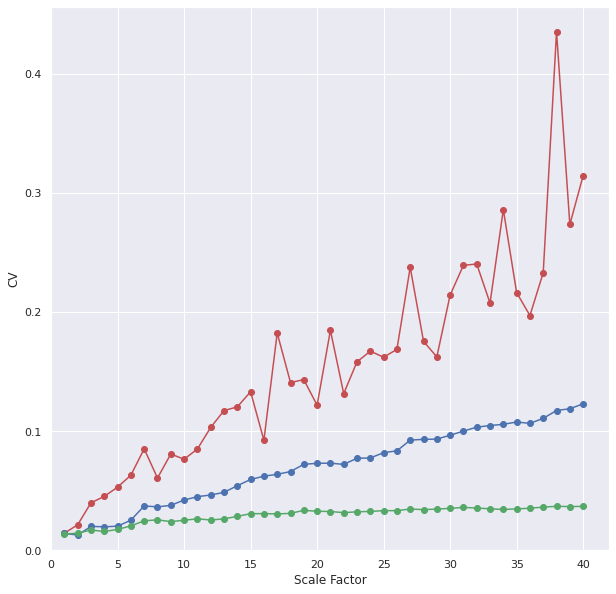

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
axes.plot(np.abs(CV_MSE), "r-o")
axes.plot(np.abs(CV_CMSE), "b-o")
axes.plot(np.abs(CV_FMSE), "g-o")
axes.set_xlabel("Scale Factor")
axes.set_ylabel("MSE")
axes.set_xlabel("Scale Factor")
axes.set_ylabel("CV")
plt.xlim(0)
plt.ylim(0)
plt.show()

In [0]:
!pip install pyentrp

In [0]:
nb_signal = 1
N = 1000
y_axis_scale = 40
m = 2

# nb_signal white noise of N samples generation
white_noise = []
for i in range(0, nb_signal):
    white_noise.append(np.abs(np.random.randn(N)))

In [0]:
from pyentrp import entropy as ent
import unittest

In [0]:
RANDOM_TIME_SERIES = np.random.rand(1000)
print(RANDOM_TIME_SERIES.shape, white_noise[0].shape)
multi_scale_entropy = ent.multiscale_entropy(white_noise[0].shape, N, maxscale = 40 )

In [0]:
print(multi_scale_entropy)